In [172]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [173]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [174]:
bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']

In [175]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [176]:
from datetime import time, timedelta
from dateutil.relativedelta import relativedelta

In [177]:
def backtest(stock_price_df, coeffs, entryZscore, exitZscore, stopLossZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 30).mean()
    df['std_30'] = df['spread'].rolling(window = 30).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore) & (df.z_score > - stopLossZscore)
    df['long_exit'] = ((df.z_score > - exitZscore) | (df.z_score < - stopLossZscore)) & ( df.z_score.shift(1) < - exitZscore) 
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore) & (df.z_score < stopLossZscore)
    df['short_exit'] = ((df.z_score < exitZscore) | (df.z_score > stopLossZscore)) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_long'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    df['drawdown'] = ffn.to_drawdown_series(df['cum rets'])
    idx = (df['drawdown'] <= -0.05) | (df['cum rets'] <= 0.95)
    
    first_idx = idx.idxmax() if idx.any() else None

# If a True value exists, set all 'cum rets' from that index onward to NaN
    if first_idx is not None:
        df.loc[first_idx:, 'cum rets'] = np.nan
    # df.loc[,'numUnits'] = np.nan

    # df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    # df['cum rets'] = df['port rets'].cumsum()
    # df['cum rets'] = df['cum rets'] + 1

    df['cum rets'] = df['cum rets'].fillna(method='pad')
    return df['cum rets'], sharpe, df['spread']

In [178]:
start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)

bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']


df = yf.download(bank_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  8 of 8 completed


In [179]:
df.to_csv('bank_test_5yr.csv')

In [180]:
df_test = pd.read_csv('bank_test_5yr.csv', parse_dates=True, index_col='Date')

In [181]:
df_test

,AXISBANK.NS,BANKBARODA.NS,CANBK.NS,HDFCBANK.NS,ICICIBANK.NS,INDUSINDBK.NS,KOTAKBANK.NS,SBIN.NS
Date,,,,,,,,
2022-01-03,696.349976,83.800003,41.090000,1519.650024,764.700012,912.299988,1824.449951,470.799988
2022-01-04,709.150024,83.900002,41.310001,1528.550049,772.849976,904.400024,1852.599976,483.500000
2022-01-05,726.900024,84.900002,42.200001,1564.849976,788.049988,903.950012,1922.150024,492.399994
2022-01-06,730.299988,86.599998,42.500000,1539.750000,785.049988,921.700012,1891.900024,491.700012
2022-01-07,730.599976,87.599998,42.459999,1550.550049,793.250000,922.250000,1904.250000,491.250000
...,...,...,...,...,...,...,...,...
2024-12-24,1078.900024,244.949997,100.550003,1798.099976,1297.250000,935.299988,1749.050049,812.049988
2024-12-26,1076.699951,246.679993,101.029999,1790.750000,1297.349976,931.950012,1752.800049,812.450012
2024-12-27,1077.449951,244.990005,100.360001,1798.250000,1307.550049,953.400024,1759.900024,799.650024


2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
zero-size array to reduction operation fmin which has no identity


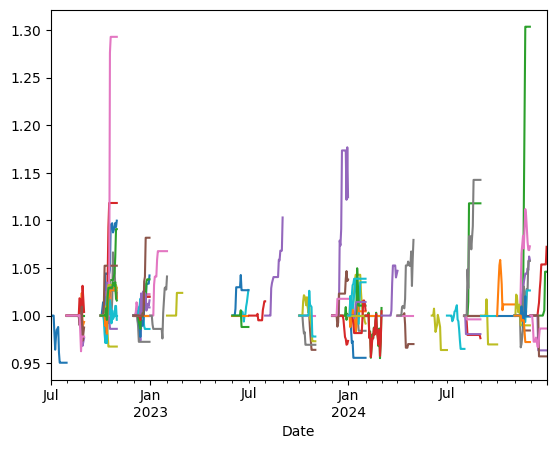

In [182]:
start_check = datetime(2022, 1, 1)

over = False
transac_dict_list = []
net_ret = []
while start_check <= datetime(2024,12,1):
    print(start_check)
    end_check = start_check + relativedelta(months=6)
    n = len(bank_tickers)
    poss_comb_bank = {}
    for i in range(n - 1):
        for j in range(i + 1, n):
            bk_group = bank_tickers[i:j + 1]
            try:
                res = coint_johansen(df_test[bk_group].loc[start_check:end_check], det_order=1, k_ar_diff=1)
            except Exception as e:
                print(e)
                over = True
                break
            if res.lr1[0] > res.cvt[0][1] and res.lr2[0] > res.cvm[0][1]:
                poss_comb_bank[(i, j + 1)] = res.evec[0]
                
    bank_ind = list(poss_comb_bank.keys())
    
    # df_test['temp'] = 0

    month_ret = 0

    for comb in bank_ind:
        coeff_vec = poss_comb_bank[comb]
        group = bank_tickers[comb[0] : comb[1]]
        # print(comb)
        try:
            res = backtest(df_test[end_check - relativedelta(days=42): end_check + relativedelta(months=1)][group], coeff_vec, 1, 0, 2)
            res[0].loc[end_check: end_check + relativedelta(months = 1)].plot()
            # df_test['temp'] += res[0]
            month_ret += max(res[0][-1], 0.95) - 1
            transac_dict_list.append({'stocks' : group, 'returns': res[0], 'sharpe' : res[1] ,'spread': res[2]})
        except Exception as e:
            print(e)
            over = True 
            break 
    
    if over:
        break
    # else:
    #     # df_test['temp'] /= len(bank_ind)
    #     # df_test['temp'].loc[end_check: end_check + relativedelta(days = 42)].plot()
    #     plt.title(f'{end_check} : {end_check + relativedelta(months = 1)}')
    #     plt.show()
    start_check = start_check + relativedelta(months = 1)
    net_ret.append(month_ret)

In [183]:
prof_count = 0
prof =0
loss_count = 0
loss = 0
for t in transac_dict_list:
    x = t['returns'][-1] - 1
    if x > 0:
        prof_count += 1
        prof += x
    elif x < 0:
        loss_count += 1
        loss += x
print(f'No. of profitable positions: {prof_count}, avg_profit = {prof/prof_count}')
print(f'No. of loss-making positions: {loss_count}, avg_loss = {loss/loss_count}')
print(f'No. of positions with no-change/no trading opportunities: {len(transac_dict_list) - prof_count - loss_count}')

No. of profitable positions: 52, avg_profit = 0.05196931326767428
No. of loss-making positions: 33, avg_loss = -0.022924199631759897
No. of positions with no-change/no trading opportunities: 22


In [184]:
np.sum(net_ret)/len(transac_dict_list)

0.01818603459879426

In [185]:
sum

1.5355892659560793

In [186]:
df_train = pd.read_csv('pharma_test.csv', parse_dates=True, index_col='Date')

In [187]:
pharma_tickers = [
    "SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS", "DIVISLAB.NS",
    "AUROPHARMA.NS", "BIOCON.NS", "LUPIN.NS", "TORNTPHARM.NS",
    "ZYDUSLIFE.NS", "GLENMARK.NS"
]

2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
zero-size array to reduction operation fmin which has no identity


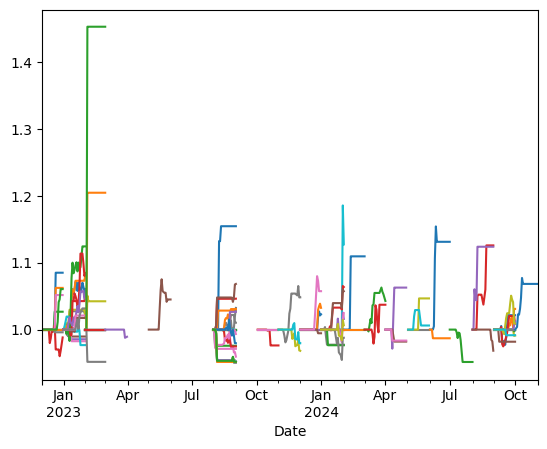

In [188]:
start_check = datetime(2022, 6, 1)
over = False
transac_dict_list = []
net_ret = []
while start_check <= datetime(2024,12,1):
    print(start_check)
    end_check = start_check + relativedelta(months=6)
    n = len(pharma_tickers)
    poss_comb_bank = {}
    for i in range(n - 1):
        for j in range(i + 1, n):
            bk_group = pharma_tickers[i:j + 1]
            try:
                res = coint_johansen(df_train[bk_group].loc[start_check:end_check], det_order=1, k_ar_diff=1)
            except Exception as e:
                print(e)
                over = True
                break
            if res.lr1[0] > res.cvt[0][1] and res.lr2[0] > res.cvm[0][1]:
                poss_comb_bank[(i, j + 1)] = res.evec[0]
                
    bank_ind = list(poss_comb_bank.keys())
    
    # df_test['temp'] = 0

    month_ret = 0

    for comb in bank_ind:
        coeff_vec = poss_comb_bank[comb]
        group = pharma_tickers[comb[0] : comb[1]]
        # print(comb)
        try:
            res = backtest(df_train[end_check - relativedelta(days=42): end_check + relativedelta(months=1)][group], coeff_vec, 1, 0, 2)
            res[0].loc[end_check: end_check + relativedelta(months = 1)].plot()
            # df_test['temp'] += res[0]
            month_ret += max(res[0][-1], 0.95) - 1
            transac_dict_list.append({'stocks' : group, 'returns': res[0], 'sharpe' : res[1] ,'spread': res[2]})
        except Exception as e:
            print(e)
            over = True 
            break 
    
    if over:
        break
    # else:
    #     # df_test['temp'] /= len(bank_ind)
    #     # df_test['temp'].loc[end_check: end_check + relativedelta(days = 42)].plot()
    #     plt.title(f'{end_check} : {end_check + relativedelta(months = 1)}')
    #     plt.show()
    start_check = start_check + relativedelta(months = 1)
    net_ret.append(month_ret)
    

In [189]:
prof_count = 0
prof =0
loss_count = 0
loss = 0
for t in transac_dict_list:
    x = t['returns'][-1] - 1
    if x > 0:
        prof_count += 1
        prof += x
    elif x < 0:
        loss_count += 1
        loss += x
print(f'No. of profitable positions: {prof_count}, avg_profit = {prof/prof_count}')
print(f'No. of loss-making positions: {loss_count}, avg_loss = {loss/loss_count}')
print(f'No. of positions with no-change/no trading opportunities: {len(transac_dict_list) - prof_count - loss_count}')

No. of profitable positions: 54, avg_profit = 0.06105323929410564
No. of loss-making positions: 38, avg_loss = -0.024474845035446113
No. of positions with no-change/no trading opportunities: 39


In [190]:
np.sum(net_ret)/len(transac_dict_list)

0.018067410767440856

In [191]:
start = datetime(2022, 1, 1)
end = datetime(2024, 12, 23)

it_tickers = [
    "TCS.NS", "INFY.NS", "WIPRO.NS", "HCLTECH.NS", "TECHM.NS",
    "LTIM.NS", "COFORGE.NS", "MPHASIS.NS", "PERSISTENT.NS"
]


df = yf.download(it_tickers, start, end)['Close']
df.tail()
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  9 of 9 completed


In [192]:
df.to_csv('it_train.csv')

2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00
2023-01-01 00:00:00
2023-02-01 00:00:00
2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00
2024-05-01 00:00:00
2024-06-01 00:00:00
2024-07-01 00:00:00
zero-size array to reduction operation fmin which has no identity


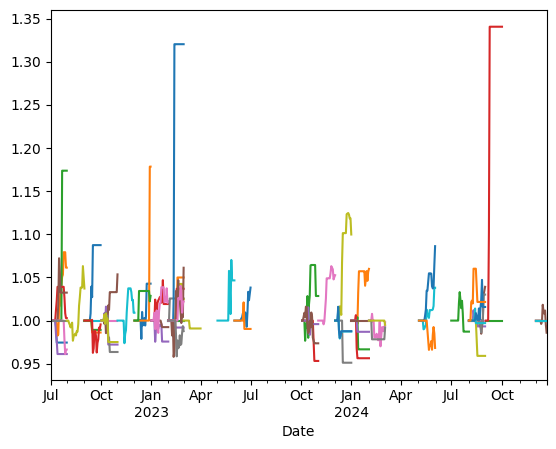

In [193]:
start_check = datetime(2022, 1, 1)
over = False
transac_dict_list = []
net_ret = []
while start_check <= datetime(2024,12,1):
    print(start_check)
    end_check = start_check + relativedelta(months=6)
    n = len(it_tickers)
    poss_comb_bank = {}
    for i in range(n - 1):
        for j in range(i + 1, n):
            bk_group = it_tickers[i:j + 1]
            try:
                res = coint_johansen(df[bk_group].loc[start_check:end_check], det_order=1, k_ar_diff=1)
            except Exception as e:
                print(e)
                over = True
                break
            if res.lr1[0] > res.cvt[0][1] and res.lr2[0] > res.cvm[0][1]:
                poss_comb_bank[(i, j + 1)] = res.evec[0]
                
    bank_ind = list(poss_comb_bank.keys())
    
    # df_test['temp'] = 0

    month_ret = 0

    for comb in bank_ind:
        coeff_vec = poss_comb_bank[comb]
        group = it_tickers[comb[0] : comb[1]]
        # print(comb)
        try:
            res = backtest(df[end_check - relativedelta(days=42): end_check + relativedelta(months=1)][group], coeff_vec, 1, 0, 2)
            res[0].loc[end_check: end_check + relativedelta(months = 1)].plot()
            # df_test['temp'] += res[0]
            month_ret += max(res[0][-1], 0.95) - 1
            transac_dict_list.append({'stocks' : group, 'returns': res[0], 'sharpe' : res[1] ,'spread': res[2]})
        except Exception as e:
            print(e)
            over = True 
            break 
    
    if over:
        break
    # else:
    #     # df_test['temp'] /= len(bank_ind)
    #     # df_test['temp'].loc[end_check: end_check + relativedelta(days = 42)].plot()
    #     plt.title(f'{end_check} : {end_check + relativedelta(months = 1)}')
    #     plt.show()
    start_check = start_check + relativedelta(months = 1)
    net_ret.append(month_ret)
    

In [194]:
sum = 0
for i in net_ret:
    sum += i

In [195]:
np.sum(net_ret)/len(transac_dict_list)

0.019194865824450985

In [196]:
# for t in transac_dict_list:
#     if t['returns'][-1] > 1:
#         (t['spread']/t['spread'].mean()).plot()
#         t['returns'].plot()
#         plt.title(f'{t['stocks']}')
#         plt.figure()

In [197]:
prof_count = 0
prof =0
loss_count = 0
loss = 0
for t in transac_dict_list:
    x = t['returns'][-1] - 1
    if x > 0:
        prof_count += 1
        prof += x
    elif x < 0:
        loss_count += 1
        loss += x
print(f'No. of profitable positions: {prof_count}, avg_profit = {prof/prof_count}')
print(f'No. of loss-making positions: {loss_count}, avg_loss = {loss/loss_count}')
print(f'No. of positions with no-change/no trading opportunities: {len(transac_dict_list) - prof_count - loss_count}')

No. of profitable positions: 33, avg_profit = 0.06627955649212429
No. of loss-making positions: 33, avg_loss = -0.019746548432849165
No. of positions with no-change/no trading opportunities: 14
